Draft to measure emmsion lines. Make model line, convolve model by appropriate lsf, fit to spectrum.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.optimize import leastsq
from astropy.modeling import functional_models

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [12]:
path = '/media/david/1tb_storage1/emergency_data/mega_muscles/v01_seds/'

In [13]:
hdul = fits.open('{}hlsp_muscles_multi_multi_gj674_broadband_v1_var-res-sed.fits'.format(path))

In [14]:
data = hdul[1].data
inst_list = hdul[2].data
inst_list

FITS_rec([(      1, 'HST', 'COS', 'G130M', 'hlsp_muscles_hst_cos_gj674_g130m_v1_component-spec.fits'),
          (  65536, 'MOD', 'LYA', 'YOUNG', 'hlsp_muscles_mod_lya_gj674_young_v1_component-spec.fits'),
          (      8, 'HST', 'STS', 'G140M', 'hlsp_muscles_hst_sts_gj674_g140m_v1_component-spec.fits'),
          (8388608, 'HST', 'STS', 'G140L', 'hlsp_muscles_hst_sts_gj674_g140l_v1_component-spec.fits'),
          (    128, 'HST', 'STS', 'G230L', 'hlsp_muscles_hst_sts_gj674_g230l_v1_component-spec.fits'),
          ( 131072, 'MOD', 'PHX', 'NA', 'hlsp_muscles_mod_phx_gj674_na_v1_component-spec.fits'),
          (    256, 'HST', 'STS', 'G430L', 'hlsp_muscles_hst_sts_gj674_g430l_v1_component-spec.fits'),
          ( 131072, 'MOD', 'PHX', 'NA', 'hlsp_muscles_mod_phx_gj674_na_v1_component-spec.fits'),
          (   2048, 'XMM', 'EPC', 'MULTI', 'hlsp_muscles_xmm_epc_gj674_multi_v1_component-spec.fits'),
          (  32768, 'MOD', 'APC', 'NA', 'hlsp_muscles_mod_apc_gj674_na_v1_component-s

In [15]:
mask = (data['WAVELENGTH'] > 1160) & (data['WAVELENGTH'] < 2000) & (data['INSTRUMENT'] != 65536)

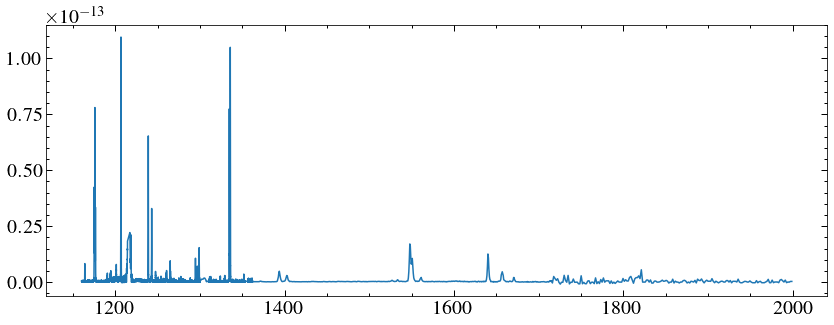

In [16]:
plt.plot(data['WAVELENGTH'][mask], data['FLUX'][mask])

In [52]:
line_list = Table.read('all_linelist.csv')

(1160.0, 1700.0)

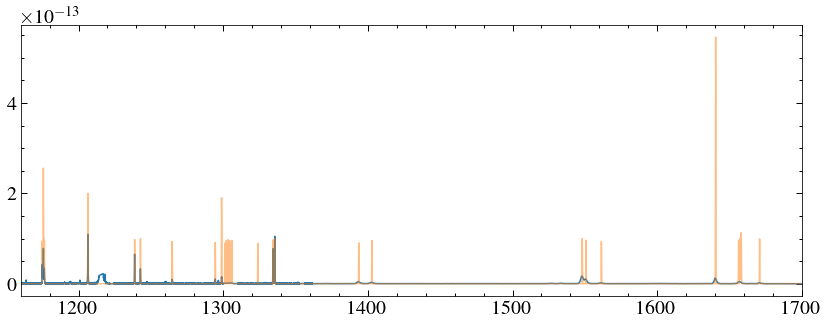

In [18]:
mod1 = models.Const1D(0)
for i in range(len(line_list)):
    amp = 1e-13
#     if line_list['Likelihood to measure'][i] == 'Low':
#         amp = amp/3
#     if line_list['Likelihood to measure'][i] == 'Medium':
#         amp = amp/2
    if line_list['Likelihood to measure'][i] == 'High':
#     mod1 = mod1+ functional_models.Voigt1D(x_0=line_list['Wavelength'][i], amplitude_L=amp, fwhm_G=0.05, fwhm_L=0.05)
        mod1 = mod1 + models.Gaussian1D(amplitude=amp, mean = line_list['Wavelength'][i], stddev=0.1)


mw = np.arange(900, 1700, 0.1)
plt.plot(data['WAVELENGTH'][mask], data['FLUX'][mask])
plt.plot(mw, mod1(mw), alpha=0.5)
plt.xlim(1160, 1700)


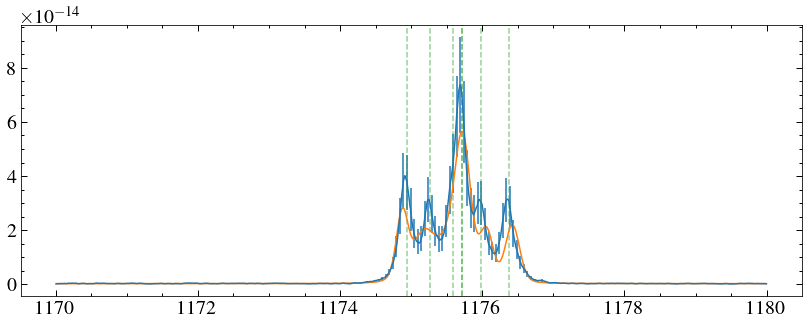

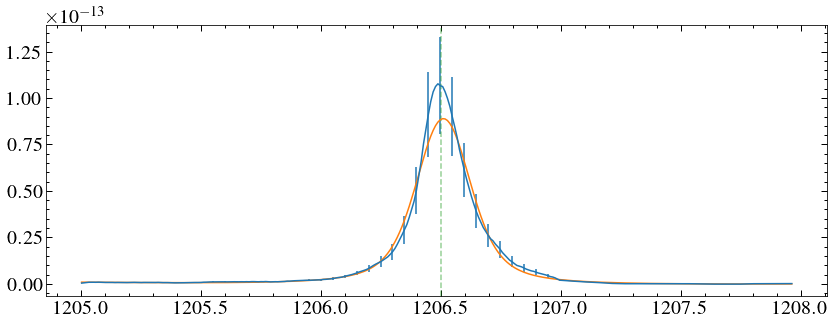

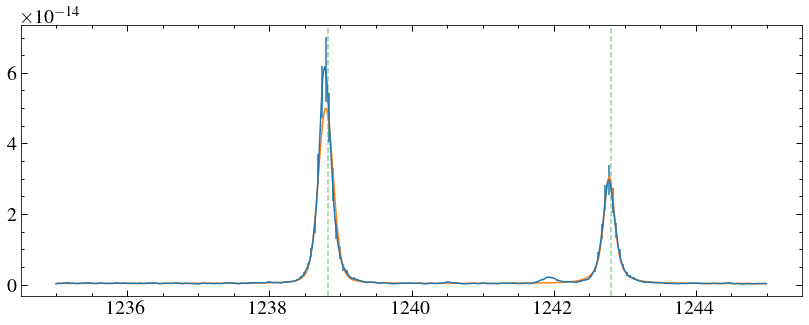

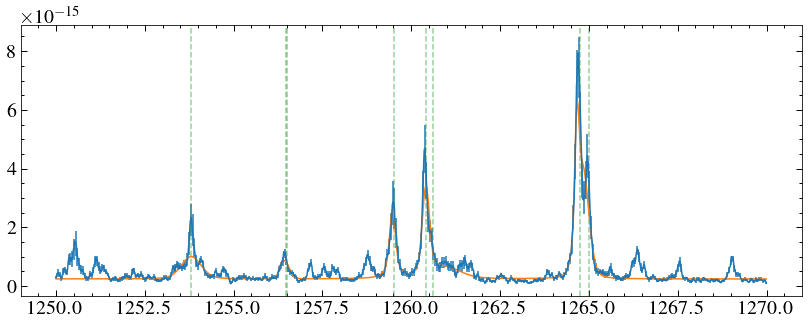

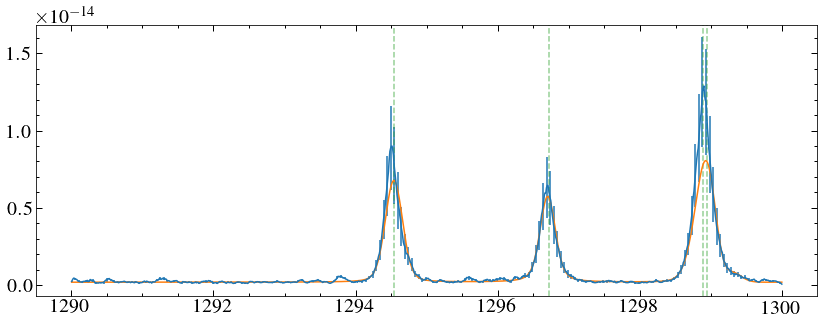

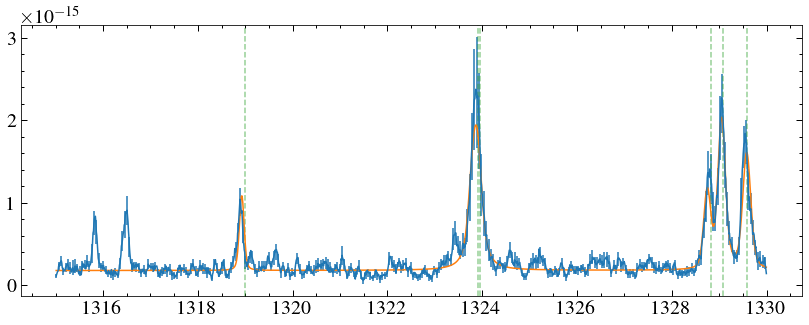

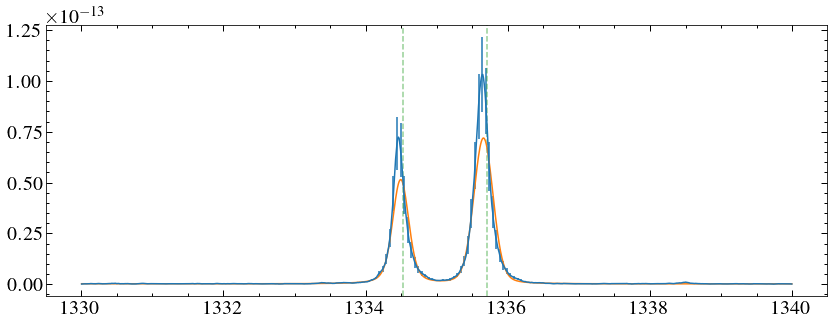

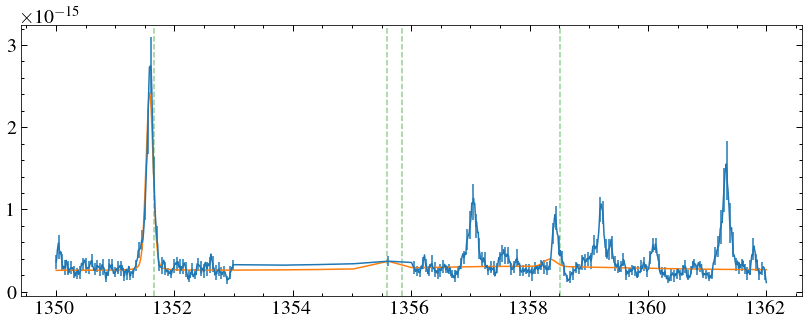

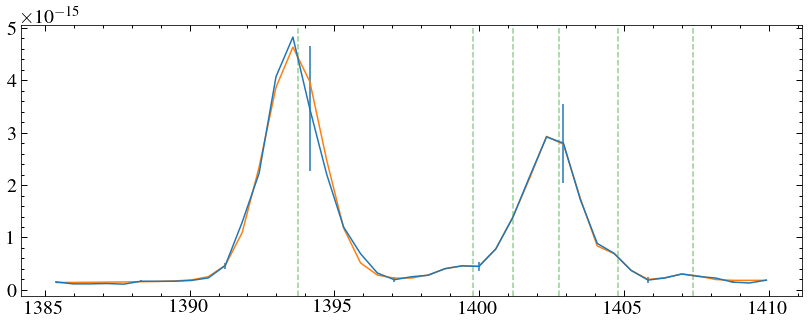

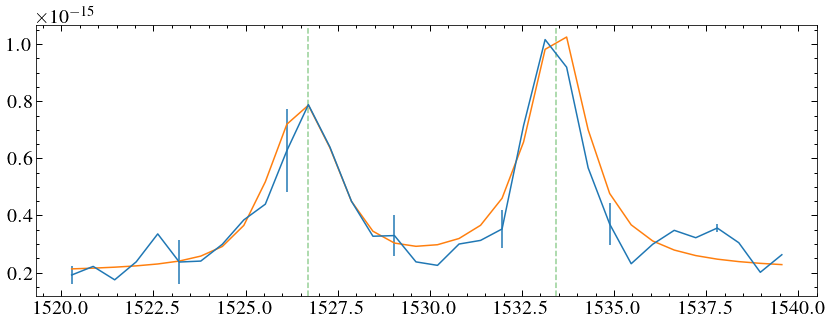

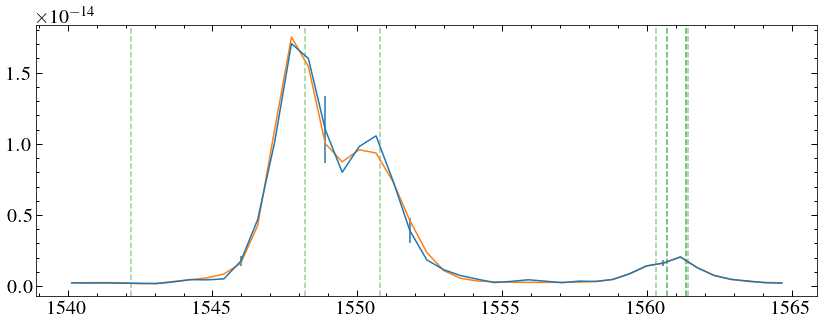

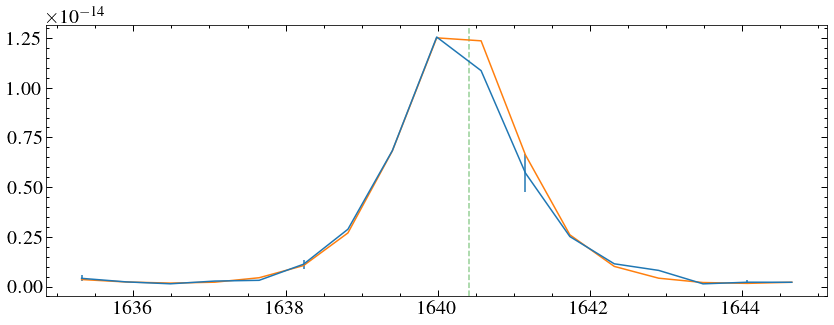

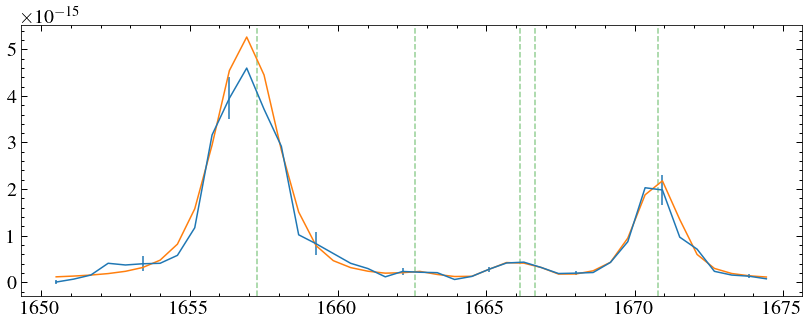

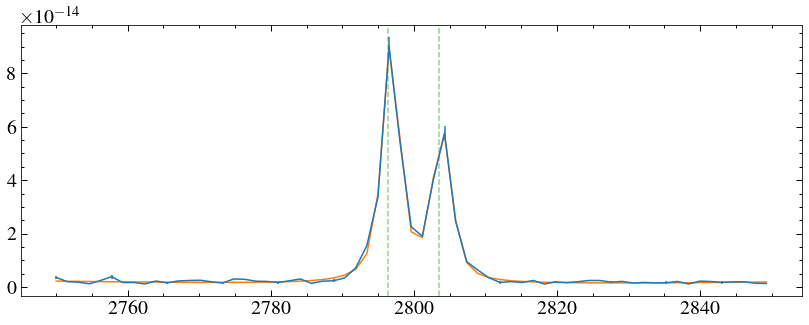

In [80]:
#50 AA chunks?
fitter = fitting.LevMarLSQFitter()
start = 1150
step = 60
w, f, e, inst = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['INSTRUMENT']
lines = line_list[(line_list['Likelihood to measure'] == 'High') | (line_list['Likelihood to measure'] == 'Medium')]['Wavelength']

chunks = [[1170, 1180], [1205, 1208], [1235, 1245], [1250, 1270], [1290, 1300], [1315, 1330], [1330, 1340], [1350, 1362], [1385, 1410], [1520, 1540], 
          [1540, 1565], [1635, 1645], [1650, 1675], [2750, 2850]]


dv_guess = -50*u.km/u.s

smooth =7 

dvs = []

for chunk in chunks:
    start, end = chunk[0], chunk[1]
    mask = (w >= start) & (w <= end)
  
    lmask = (lines >= start) & (lines <= end)
    if len(lines[lmask]) > 0:
#         plt.plot(w[mask], f[mask])
        fi, ei = f[mask], e[mask]
      
#         mod = models.Const1D(0)
        mod = models.Polynomial1D(2)
        std_guess = 0.5
        if np.median(inst[mask]) <= 2:
            std_guess = 0.1
            fi = convolve(fi,Box1DKernel(smooth))
            ei = convolve(ei,Box1DKernel(smooth))/smooth**0.5
            
        plt.errorbar(w[mask], fi, yerr =ei, errorevery=5)
#         print(std_guess)
        for line in lines[lmask]:
            line_guess = dv_guess.to(u.AA, equivalencies = u.doppler_optical(line*u.AA)).value
#             mod = mod+  models.Gaussian1D(amplitude=np.max(fi), mean = line_guess, stddev=std_guess)
            mod = mod + functional_models.Voigt1D(x_0=line_guess, amplitude_L=np.max(fi), fwhm_G=std_guess, fwhm_L=std_guess*0.5)
            plt.axvline(line, ls='--', c='C2', alpha =0.5)
#             plt.axvline(line_guess, ls='--', c='C3', alpha =0.5)
        gg_fit = fitter(mod, w[mask], fi, weights = 1/ei, maxiter=1000)
#         print(gg_fit)
        for i in range(len(lines[lmask])):
            obs_line = gg_fit[i+1].x_0*u.AA
#             obs_line = gg_fit[i+1].mean*u.AA
            dvs.append(obs_line.to(u.km/u.s, equivalencies = u.doppler_optical(lines[lmask][i]*u.AA)))
        plt.plot(w[mask], gg_fit(w[mask]))
        plt.show()
#     start += step
    

What about just doublets to get the rv?

In [74]:
dvs = np.array([dv.value for dv in dvs])

-4921.031805963662 -17.724338602945636 321914.58455832425


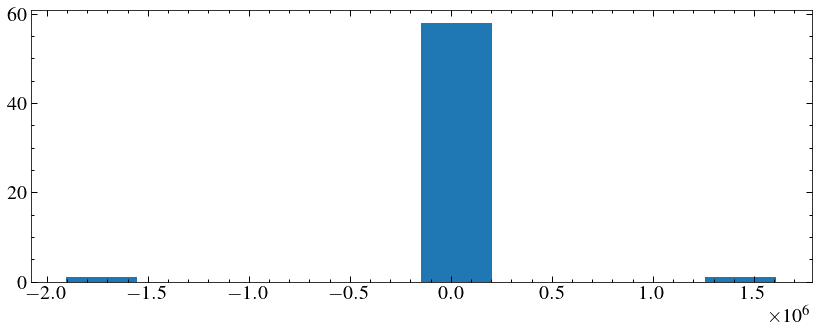

In [75]:
plt.hist(dvs)
print(np.mean(dvs), np.median(dvs), np.std(dvs))